# Cognitive decline

We need a dataframe that has all BL data, but also the cog scores at different intervals.


In [318]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from collections import Counter
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [319]:
adni = pd.read_csv(os.path.join("data", "ADNIMERGE_19Jun2025.csv"))

C:\Users\huw\AppData\Local\Temp\ipykernel_3360\1138183190.py:1: DtypeWarning:

Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.



In [320]:
adni["PTID"].dtype

dtype('O')

In [321]:
pet_df = pd.read_csv(os.path.join('data', 'CSF_COG_PET_data.csv'))
pet_df.shape

pet_pt_id = list(pet_df['PTID'])

pet_pt_id

['082_S_5282',
 '100_S_5280',
 '027_S_5277',
 '135_S_5275',
 '135_S_5269',
 '007_S_5265',
 '032_S_5263',
 '033_S_5259',
 '130_S_5258',
 '002_S_5256',
 '009_S_5252',
 '016_S_5251',
 '041_S_5244',
 '126_S_5243',
 '019_S_5242',
 '021_S_5237',
 '021_S_5236',
 '114_S_5234',
 '130_S_5231',
 '073_S_5227',
 '009_S_5224',
 '029_S_5219',
 '126_S_5214',
 '036_S_5210',
 '067_S_5205',
 '020_S_5203',
 '127_S_5200',
 '057_S_5199',
 '033_S_5198',
 '027_S_5197',
 '007_S_5196',
 '021_S_5194',
 '003_S_5187',
 '127_S_5185',
 '002_S_5178',
 '009_S_5176',
 '130_S_5175',
 '013_S_5171',
 '027_S_5169',
 '003_S_5165',
 '037_S_5162',
 '067_S_5159',
 '012_S_5157',
 '003_S_5154',
 '130_S_5142',
 '020_S_5140',
 '029_S_5135',
 '012_S_4545',
 '027_S_5127',
 '128_S_5123',
 '005_S_5119',
 '027_S_5118',
 '036_S_5112',
 '027_S_5109',
 '100_S_5106',
 '100_S_5102',
 '041_S_5100',
 '041_S_5097',
 '100_S_5096',
 '127_S_5095',
 '100_S_5091',
 '073_S_5090',
 '033_S_5087',
 '027_S_5083',
 '041_S_5082',
 '041_S_5078',
 '053_S_50

In [322]:
adni["PTID"] = adni["PTID"].astype(str).str.strip()
pet_pt_id = [str(pid).strip() for pid in pet_pt_id]

filtered_df = adni[adni["PTID"].isin(pet_pt_id)]

filtered_df.columns

Index(['RID', 'COLPROT', 'ORIGPROT', 'PTID', 'SITE', 'VISCODE', 'EXAMDATE',
       'DX_bl', 'AGE', 'PTGENDER',
       ...
       'PTAU_bl', 'FDG_bl', 'PIB_bl', 'AV45_bl', 'FBB_bl', 'Years_bl',
       'Month_bl', 'Month', 'M', 'update_stamp'],
      dtype='object', length=116)

In [323]:
filtered_df['Month'].value_counts()

Month
0      547
6      526
3      493
24     465
12     464
18     386
48     258
36     218
30     132
72      99
84      89
78      88
60      87
90      85
66      83
96      77
102     66
108     64
114     52
120     39
126     38
54      36
42      35
132     23
138      8
Name: count, dtype: int64

In [324]:
# 6 month intervals for 2 years 0,6,12,24

bl_df = filtered_df[filtered_df["M"] == 0]
sixm_df = filtered_df[filtered_df["M"] == 6]
twelvem_df = filtered_df[filtered_df["M"] == 12]
eighteenm_df = filtered_df[filtered_df["M"] == 18]
twentyfourm_df = filtered_df[filtered_df["M"] == 24]

eighteenm_df["DX"]

2940     NaN
3067     NaN
3210     NaN
3401     NaN
3427     NaN
        ... 
12631    NaN
12637    NaN
12650    NaN
12658    NaN
12803    NaN
Name: DX, Length: 382, dtype: object

We want to include domain specific cognitive test scores and not just total composite tests. Do we use the patients self declared scores or the study partner

1. EcogSPPlan_bl
2. EcogPtMem_bl
3. EcogPtLang_bl
4. EcogPtVisspat_bl
5. EcogPtPlan_bl
6. EcogPtOrgan_bl
7. EcogPtDivatt_bl
8. EcogPtTotal_bl
9. EcogSPMem_bl
10. EcogSPLang_bl
11. EcogSPVisspat_bl
12. EcogSPOrgan_bl
13. EcogSPDivatt_bl


1. EcogSPPlan
2. EcogPtMem
3. EcogPtLang
4. EcogPtVisspat
5. EcogPtPlan
6. EcogPtOrgan
7. EcogPtDivatt
8. EcogPtTotal
9. EcogSPMem
10. EcogSPLang
11. EcogSPVisspat
12. EcogSPOrgan
13. EcogSPDivatt

In [325]:
pt_cals = ["PTID","PTGENDER" ,"AGE", "M", "Gender", "PTRACCAT", "PTEDUCAT"]

bl_cog_data = ["DX_bl", "EcogSPPlan_bl", "EcogPtMem_bl", "EcogPtLang_bl", "EcogPtVisspat_bl", "EcogPtPlan_bl", "EcogPtOrgan_bl", 
               "EcogPtDivatt_bl", "EcogPtTotal_bl", "EcogSPMem_bl", "EcogSPLang_bl", "EcogSPVisspat_bl", "EcogSPOrgan_bl", "EcogSPDivatt_bl", "RAVLT_learning_bl" ]

followup_cog_data = ["DX","EcogSPPlan", "EcogPtMem", "EcogPtLang", "EcogPtVisspat", "EcogPtPlan", "EcogPtOrgan", 
                     "EcogPtDivatt", "EcogPtTotal", "EcogSPMem", "EcogSPLang", "EcogSPVisspat", "EcogSPOrgan", "EcogSPDivatt", "RAVLT_learning"]



In [326]:
bl_df = bl_df.filter(pt_cals + bl_cog_data)

bl_df.dropna()

,PTID,PTGENDER,AGE,M,PTRACCAT,PTEDUCAT,DX_bl,EcogSPPlan_bl,EcogPtMem_bl,EcogPtLang_bl,...,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,RAVLT_learning_bl
76,100_S_5280,Male,67.5,0,Black,16,SMC,1.0,1.87500,1.00000,...,1.0,2.00000,2.00,1.43590,1.625,1.11111,1.28571,1.25,1.00,7.0
159,027_S_5277,Female,71.8,0,White,15,SMC,1.0,2.75000,2.22222,...,1.4,1.40000,1.50,1.84211,1.875,1.00000,1.00000,1.00,1.75,8.0
217,135_S_5275,Female,78.0,0,White,12,AD,2.8,2.00000,1.55556,...,1.2,1.00000,1.00,1.35897,3.000,3.00000,2.20000,2.80,3.00,1.0
428,135_S_5269,Male,64.9,0,White,16,SMC,1.0,1.37500,1.22222,...,1.2,1.00000,1.25,1.17949,1.000,1.00000,1.00000,1.00,1.00,6.0
667,007_S_5265,Female,75.1,0,White,18,SMC,1.0,1.62500,1.88889,...,1.2,1.50000,3.00,1.64103,1.000,1.00000,1.00000,1.00,1.00,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12765,127_S_5266,Male,65.9,0,White,16,SMC,1.0,1.50000,1.00000,...,1.0,1.00000,1.25,1.12821,1.250,1.00000,1.00000,1.00,1.00,9.0
12771,053_S_5272,Female,69.9,0,White,8,SMC,1.0,1.62500,1.22222,...,1.0,1.00000,1.25,1.23077,1.000,1.00000,1.00000,1.00,1.00,5.0
12774,053_S_5287,Female,78.9,0,White,16,SMC,2.2,1.75000,1.44444,...,1.0,1.00000,1.00,1.30769,2.125,1.33333,1.85714,1.80,2.00,10.0
12776,027_S_5288,Female,81.9,0,White,18,SMC,1.0,1.14286,1.44444,...,1.0,1.16667,2.50,1.31579,1.000,1.00000,1.00000,1.00,1.00,6.0


In [327]:
sixm_df = sixm_df.filter(["PTID", "M"] + followup_cog_data)

sixm_df.dropna()

,PTID,M,DX,EcogSPPlan,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPOrgan,EcogSPDivatt,RAVLT_learning
153,027_S_5277,6,CN,1.0,3.25000,2.00000,1.42857,2.8,1.50000,2.75,2.25641,2.000,1.00000,1.00000,1.00000,2.00,6.0
169,135_S_5275,6,Dementia,2.2,2.62500,2.55556,2.42857,2.6,1.83333,1.75,2.35897,2.625,2.33333,1.85714,2.33333,2.00,1.0
421,135_S_5269,6,CN,1.0,1.50000,1.00000,1.14286,1.0,1.16667,1.75,1.23077,1.000,1.00000,1.28571,1.00000,1.50,5.0
666,007_S_5265,6,CN,1.0,2.00000,1.55556,1.33333,1.0,2.33333,4.00,1.92105,1.000,1.00000,1.00000,1.00000,1.00,4.0
700,032_S_5263,6,CN,1.0,3.28571,1.55556,1.00000,2.0,2.00000,3.75,2.25000,2.500,1.22222,1.85714,1.50000,3.25,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12763,041_S_5253,6,CN,1.2,2.37500,2.22222,1.57143,1.6,1.66667,2.00,1.94872,2.500,1.66667,1.00000,1.50000,1.50,4.0
12766,127_S_5266,6,CN,1.0,1.37500,1.11111,1.00000,1.2,1.00000,1.25,1.15385,1.625,1.00000,1.00000,1.00000,1.25,12.0
12772,053_S_5272,6,CN,1.0,1.50000,1.55556,1.00000,1.0,1.00000,1.50,1.28205,1.000,1.00000,1.00000,1.00000,1.00,6.0
12777,027_S_5288,6,CN,1.0,1.37500,1.66667,1.28571,1.0,1.83333,2.75,1.58974,1.000,1.00000,1.00000,1.00000,1.00,5.0


In [328]:
twelvem_df = twelvem_df.filter(["PTID", "M"] + followup_cog_data)

twelvem_df.dropna()

,PTID,M,DX,EcogSPPlan,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPOrgan,EcogSPDivatt,RAVLT_learning
676,032_S_5263,12,CN,1.8,2.500,1.44444,1.28571,1.2,1.50000,3.00,1.76923,3.125,2.00000,2.42857,3.00000,3.75,1.0
3146,029_S_5135,12,MCI,1.2,1.125,1.11111,1.14286,1.0,1.00000,2.00,1.17949,1.125,1.11111,1.00000,1.00000,2.25,3.0
3171,027_S_5127,12,CN,1.2,1.625,1.44444,1.00000,1.0,1.33333,2.00,1.38462,1.625,1.11111,1.14286,1.80000,1.75,5.0
3184,128_S_5123,12,Dementia,2.6,2.000,1.33333,1.00000,1.0,1.00000,1.00,1.28205,2.500,1.44444,1.85714,2.16667,2.25,6.0
3191,005_S_5119,12,Dementia,4.0,1.625,1.22222,1.28571,1.0,1.16667,1.25,1.28205,4.000,3.66667,3.85714,3.83333,4.00,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12691,021_S_5099,12,MCI,1.8,3.500,3.33333,3.57143,2.8,3.50000,3.75,3.41026,1.875,1.55556,1.57143,1.66667,2.00,5.0
12701,135_S_5113,12,CN,1.0,1.000,1.33333,1.14286,1.0,1.00000,1.00,1.10256,1.000,1.00000,1.00000,1.00000,1.00,4.0
12707,012_S_5121,12,MCI,2.4,1.500,1.44444,1.28571,1.6,1.33333,1.75,1.46154,3.875,2.44444,1.85714,3.83333,3.75,3.0
12721,041_S_5141,12,CN,1.0,1.750,1.55556,1.14286,1.0,1.83333,1.00,1.43590,1.375,1.00000,1.00000,1.00000,1.00,3.0


In [329]:
eighteenm_df = eighteenm_df.filter(["PTID", "M"] + followup_cog_data)

eighteenm_df.dropna()

,PTID,M,DX,EcogSPPlan,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPOrgan,EcogSPDivatt,RAVLT_learning


In [330]:
twentyfourm_df = twentyfourm_df.filter(["PTID", "M"] + followup_cog_data)

twentyfourm_df.dropna()

,PTID,M,DX,EcogSPPlan,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPOrgan,EcogSPDivatt,RAVLT_learning
138,027_S_5277,24,CN,1.0,2.500,2.66667,1.28571,1.2,1.60000,1.00,1.86842,1.375,1.00000,1.14286,1.00000,1.00,1.0
401,135_S_5269,24,CN,1.0,1.125,1.00000,1.00000,1.0,1.00000,1.00,1.02564,1.125,1.11111,1.00000,1.00000,1.25,5.0
659,007_S_5265,24,CN,1.0,2.625,3.00000,2.14286,1.4,2.33333,3.50,2.51282,1.125,1.00000,1.00000,1.00000,1.00,11.0
675,032_S_5263,24,MCI,1.4,2.000,1.00000,1.00000,1.0,1.00000,1.75,1.28205,2.750,1.88889,1.42857,1.66667,3.00,5.0
859,130_S_5258,24,CN,1.0,1.875,1.33333,1.00000,1.0,1.00000,1.25,1.28205,1.000,1.00000,1.00000,1.00000,1.00,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12775,053_S_5287,24,CN,2.4,1.500,1.44444,1.71429,1.0,1.00000,1.00,1.34211,2.625,1.22222,2.28571,2.66667,3.00,5.0
12778,027_S_5288,24,CN,1.4,1.875,1.55556,1.00000,1.0,1.16667,2.50,1.48718,1.000,1.00000,1.00000,1.00000,1.25,6.0
12804,031_S_4021,24,CN,1.0,1.000,1.00000,1.00000,1.0,1.00000,1.00,1.00000,1.500,1.77778,1.00000,1.16667,2.00,5.0
12806,123_S_4806,24,MCI,3.8,2.375,2.55556,2.57143,2.2,2.83333,3.00,2.56410,4.000,3.77778,3.14286,4.00000,4.00,5.0


In [331]:
sixm_df.rename(columns={col: f"{col}_{sixm_df['M'].iloc[0]}" for col in followup_cog_data}, inplace=True)

In [332]:
sixm_df

,PTID,M,DX_6,EcogSPPlan_6,EcogPtMem_6,EcogPtLang_6,EcogPtVisspat_6,EcogPtPlan_6,EcogPtOrgan_6,EcogPtDivatt_6,EcogPtTotal_6,EcogSPMem_6,EcogSPLang_6,EcogSPVisspat_6,EcogSPOrgan_6,EcogSPDivatt_6,RAVLT_learning_6
54,100_S_5280,6,CN,1.2,1.875,1.00000,1.00000,1.2,1.40000,1.25,1.28947,1.750,1.11111,1.33333,NaN,1.25,6.0
153,027_S_5277,6,CN,1.0,3.250,2.00000,1.42857,2.8,1.50000,2.75,2.25641,2.000,1.00000,1.00000,1.00000,2.00,6.0
169,135_S_5275,6,Dementia,2.2,2.625,2.55556,2.42857,2.6,1.83333,1.75,2.35897,2.625,2.33333,1.85714,2.33333,2.00,1.0
421,135_S_5269,6,CN,1.0,1.500,1.00000,1.14286,1.0,1.16667,1.75,1.23077,1.000,1.00000,1.28571,1.00000,1.50,5.0
666,007_S_5265,6,CN,1.0,2.000,1.55556,1.33333,1.0,2.33333,4.00,1.92105,1.000,1.00000,1.00000,1.00000,1.00,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12763,041_S_5253,6,CN,1.2,2.375,2.22222,1.57143,1.6,1.66667,2.00,1.94872,2.500,1.66667,1.00000,1.50000,1.50,4.0
12766,127_S_5266,6,CN,1.0,1.375,1.11111,1.00000,1.2,1.00000,1.25,1.15385,1.625,1.00000,1.00000,1.00000,1.25,12.0
12772,053_S_5272,6,CN,1.0,1.500,1.55556,1.00000,1.0,1.00000,1.50,1.28205,1.000,1.00000,1.00000,1.00000,1.00,6.0
12777,027_S_5288,6,CN,1.0,1.375,1.66667,1.28571,1.0,1.83333,2.75,1.58974,1.000,1.00000,1.00000,1.00000,1.00,5.0


In [333]:
twelvem_df.rename(columns={col: f"{col}_{twelvem_df['M'].iloc[0]}" for col in followup_cog_data}, inplace=True)
twelvem_df

,PTID,M,DX_12,EcogSPPlan_12,EcogPtMem_12,EcogPtLang_12,EcogPtVisspat_12,EcogPtPlan_12,EcogPtOrgan_12,EcogPtDivatt_12,EcogPtTotal_12,EcogSPMem_12,EcogSPLang_12,EcogSPVisspat_12,EcogSPOrgan_12,EcogSPDivatt_12,RAVLT_learning_12
676,032_S_5263,12,CN,1.8,2.500,1.44444,1.28571,1.2,1.50000,3.00,1.76923,3.125,2.00000,2.42857,3.00000,3.75000,1.0
868,130_S_5258,12,CN,1.4,1.875,1.55556,1.00000,1.4,2.16667,2.00,1.64103,1.125,1.00000,1.00000,NaN,1.75000,7.0
2894,007_S_5196,12,Dementia,3.2,2.625,2.11111,1.28571,1.4,1.60000,2.00,1.89474,3.750,2.62500,1.66667,NaN,3.66667,3.0
3073,003_S_5165,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3088,037_S_5162,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12696,027_S_5110,12,CN,1.0,3.000,2.77778,1.50000,1.6,NaN,3.00,2.51429,1.750,1.66667,1.00000,1.50000,1.25000,7.0
12701,135_S_5113,12,CN,1.0,1.000,1.33333,1.14286,1.0,1.00000,1.00,1.10256,1.000,1.00000,1.00000,1.00000,1.00000,4.0
12707,012_S_5121,12,MCI,2.4,1.500,1.44444,1.28571,1.6,1.33333,1.75,1.46154,3.875,2.44444,1.85714,3.83333,3.75000,3.0
12721,041_S_5141,12,CN,1.0,1.750,1.55556,1.14286,1.0,1.83333,1.00,1.43590,1.375,1.00000,1.00000,1.00000,1.00000,3.0


In [334]:
twentyfourm_df.rename(columns={col: f"{col}_{twentyfourm_df['M'].iloc[0]}" for col in followup_cog_data}, inplace=True)
twentyfourm_df

,PTID,M,DX_24,EcogSPPlan_24,EcogPtMem_24,EcogPtLang_24,EcogPtVisspat_24,EcogPtPlan_24,EcogPtOrgan_24,EcogPtDivatt_24,EcogPtTotal_24,EcogSPMem_24,EcogSPLang_24,EcogSPVisspat_24,EcogSPOrgan_24,EcogSPDivatt_24,RAVLT_learning_24
49,100_S_5280,24,CN,NaN,1.625,1.11111,1.14286,1.2,1.66667,1.50,1.35897,NaN,NaN,NaN,NaN,NaN,6.0
138,027_S_5277,24,CN,1.0,2.500,2.66667,1.28571,1.2,1.60000,1.00,1.86842,1.375,1.00000,1.14286,1.00000,1.00,1.0
401,135_S_5269,24,CN,1.0,1.125,1.00000,1.00000,1.0,1.00000,1.00,1.02564,1.125,1.11111,1.00000,1.00000,1.25,5.0
659,007_S_5265,24,CN,1.0,2.625,3.00000,2.14286,1.4,2.33333,3.50,2.51282,1.125,1.00000,1.00000,1.00000,1.00,11.0
675,032_S_5263,24,MCI,1.4,2.000,1.00000,1.00000,1.0,1.00000,1.75,1.28205,2.750,1.88889,1.42857,1.66667,3.00,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12775,053_S_5287,24,CN,2.4,1.500,1.44444,1.71429,1.0,1.00000,1.00,1.34211,2.625,1.22222,2.28571,2.66667,3.00,5.0
12778,027_S_5288,24,CN,1.4,1.875,1.55556,1.00000,1.0,1.16667,2.50,1.48718,1.000,1.00000,1.00000,1.00000,1.25,6.0
12804,031_S_4021,24,CN,1.0,1.000,1.00000,1.00000,1.0,1.00000,1.00,1.00000,1.500,1.77778,1.00000,1.16667,2.00,5.0
12806,123_S_4806,24,MCI,3.8,2.375,2.55556,2.57143,2.2,2.83333,3.00,2.56410,4.000,3.77778,3.14286,4.00000,4.00,5.0


In [335]:
bl_6m_df = bl_df.merge(sixm_df, on = "PTID")
bl_6m_df = bl_6m_df.drop(["M_x", "M_y"], axis= 1)
bl_6m_df

,PTID,PTGENDER,AGE,PTRACCAT,PTEDUCAT,DX_bl,EcogSPPlan_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,...,EcogPtPlan_6,EcogPtOrgan_6,EcogPtDivatt_6,EcogPtTotal_6,EcogSPMem_6,EcogSPLang_6,EcogSPVisspat_6,EcogSPOrgan_6,EcogSPDivatt_6,RAVLT_learning_6
0,082_S_5282,Male,66.9,White,17,SMC,1.2,NaN,NaN,NaN,...,1.4,1.80000,2.50,1.78378,1.000,1.00000,1.14286,1.00000,1.00,7.0
1,100_S_5280,Male,67.5,Black,16,SMC,1.0,1.87500,1.00000,1.00000,...,1.2,1.40000,1.25,1.28947,1.750,1.11111,1.33333,NaN,1.25,6.0
2,027_S_5277,Female,71.8,White,15,SMC,1.0,2.75000,2.22222,1.14286,...,2.8,1.50000,2.75,2.25641,2.000,1.00000,1.00000,1.00000,2.00,6.0
3,135_S_5275,Female,78.0,White,12,AD,2.8,2.00000,1.55556,1.00000,...,2.6,1.83333,1.75,2.35897,2.625,2.33333,1.85714,2.33333,2.00,1.0
4,135_S_5269,Male,64.9,White,16,SMC,1.0,1.37500,1.22222,1.00000,...,1.0,1.16667,1.75,1.23077,1.000,1.00000,1.28571,1.00000,1.50,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,041_S_5253,Male,68.1,White,18,SMC,1.4,3.00000,2.77778,2.00000,...,1.6,1.66667,2.00,1.94872,2.500,1.66667,1.00000,1.50000,1.50,4.0
528,127_S_5266,Male,65.9,White,16,SMC,1.0,1.50000,1.00000,1.00000,...,1.2,1.00000,1.25,1.15385,1.625,1.00000,1.00000,1.00000,1.25,12.0
529,053_S_5272,Female,69.9,White,8,SMC,1.0,1.62500,1.22222,1.14286,...,1.0,1.00000,1.50,1.28205,1.000,1.00000,1.00000,1.00000,1.00,6.0
530,027_S_5288,Female,81.9,White,18,SMC,1.0,1.14286,1.44444,1.00000,...,1.0,1.83333,2.75,1.58974,1.000,1.00000,1.00000,1.00000,1.00,5.0


In [336]:
bl_6m_12m_df = bl_6m_df.merge(twelvem_df, on = "PTID")
bl_6m_12m_df = bl_6m_12m_df.drop(["M"], axis= 1)
bl_6m_12m_df.columns

Index(['PTID', 'PTGENDER', 'AGE', 'PTRACCAT', 'PTEDUCAT', 'DX_bl',
       'EcogSPPlan_bl', 'EcogPtMem_bl', 'EcogPtLang_bl', 'EcogPtVisspat_bl',
       'EcogPtPlan_bl', 'EcogPtOrgan_bl', 'EcogPtDivatt_bl', 'EcogPtTotal_bl',
       'EcogSPMem_bl', 'EcogSPLang_bl', 'EcogSPVisspat_bl', 'EcogSPOrgan_bl',
       'EcogSPDivatt_bl', 'RAVLT_learning_bl', 'DX_6', 'EcogSPPlan_6',
       'EcogPtMem_6', 'EcogPtLang_6', 'EcogPtVisspat_6', 'EcogPtPlan_6',
       'EcogPtOrgan_6', 'EcogPtDivatt_6', 'EcogPtTotal_6', 'EcogSPMem_6',
       'EcogSPLang_6', 'EcogSPVisspat_6', 'EcogSPOrgan_6', 'EcogSPDivatt_6',
       'RAVLT_learning_6', 'DX_12', 'EcogSPPlan_12', 'EcogPtMem_12',
       'EcogPtLang_12', 'EcogPtVisspat_12', 'EcogPtPlan_12', 'EcogPtOrgan_12',
       'EcogPtDivatt_12', 'EcogPtTotal_12', 'EcogSPMem_12', 'EcogSPLang_12',
       'EcogSPVisspat_12', 'EcogSPOrgan_12', 'EcogSPDivatt_12',
       'RAVLT_learning_12'],
      dtype='object')

In [337]:
full_df = bl_6m_12m_df.merge(twentyfourm_df, on = "PTID")
full_df = full_df.drop(["M"], axis= 1)
full_df.columns

Index(['PTID', 'PTGENDER', 'AGE', 'PTRACCAT', 'PTEDUCAT', 'DX_bl',
       'EcogSPPlan_bl', 'EcogPtMem_bl', 'EcogPtLang_bl', 'EcogPtVisspat_bl',
       'EcogPtPlan_bl', 'EcogPtOrgan_bl', 'EcogPtDivatt_bl', 'EcogPtTotal_bl',
       'EcogSPMem_bl', 'EcogSPLang_bl', 'EcogSPVisspat_bl', 'EcogSPOrgan_bl',
       'EcogSPDivatt_bl', 'RAVLT_learning_bl', 'DX_6', 'EcogSPPlan_6',
       'EcogPtMem_6', 'EcogPtLang_6', 'EcogPtVisspat_6', 'EcogPtPlan_6',
       'EcogPtOrgan_6', 'EcogPtDivatt_6', 'EcogPtTotal_6', 'EcogSPMem_6',
       'EcogSPLang_6', 'EcogSPVisspat_6', 'EcogSPOrgan_6', 'EcogSPDivatt_6',
       'RAVLT_learning_6', 'DX_12', 'EcogSPPlan_12', 'EcogPtMem_12',
       'EcogPtLang_12', 'EcogPtVisspat_12', 'EcogPtPlan_12', 'EcogPtOrgan_12',
       'EcogPtDivatt_12', 'EcogPtTotal_12', 'EcogSPMem_12', 'EcogSPLang_12',
       'EcogSPVisspat_12', 'EcogSPOrgan_12', 'EcogSPDivatt_12',
       'RAVLT_learning_12', 'DX_24', 'EcogSPPlan_24', 'EcogPtMem_24',
       'EcogPtLang_24', 'EcogPtVisspat_24', '

In [338]:
full_df = full_df.dropna()

In [339]:
# Define the timepoints and their labels
dx_cols = ["DX_bl", "DX_6", "DX_12", "DX_24"]
months = [0, 6, 12, 24]

# Create labels like "CN (0m)", "MCI (6m)", etc.
all_labels = sorted(set(
    f"{dx} ({month}m)"
    for col, month in zip(dx_cols, months)
    for dx in full_df[col].dropna().unique()
))
label_to_index = {label: i for i, label in enumerate(all_labels)}

# Count transitions between consecutive timepoints
links = Counter()
for _, row in full_df.iterrows():
    for i in range(len(dx_cols) - 1):
        src_label = f"{row[dx_cols[i]]} ({months[i]}m)"
        tgt_label = f"{row[dx_cols[i+1]]} ({months[i+1]}m)"
        if pd.notnull(row[dx_cols[i]]) and pd.notnull(row[dx_cols[i+1]]):
            links[(src_label, tgt_label)] += 1

# Convert to source, target, value format
source = [label_to_index[src] for src, tgt in links.keys()]
target = [label_to_index[tgt] for src, tgt in links.keys()]
value = list(links.values())

# Plot
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(title_text="Diagnosis Transitions Over Time", font_size=12)
fig.show()

In [340]:
domains = ["EcogPtMem", "EcogPtLang", "EcogPtVisspat", "EcogPtPlan", 
           "EcogPtOrgan", "EcogPtDivatt", "EcogPtTotal", "RAVLT_learning"]

# Melt all *_bl, *_6, *_12, *_24 versions of those domains
id_vars = ["PTID", "DX_bl"]
value_vars = []

# Build full list of ECog domain/timepoint columns
for domain in domains:
    for t in ["bl", "6", "12", "24"]:
        value_vars.append(f"{domain}_{t}")

# Melt to long format
long_df = pd.melt(
    full_df,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name="Domain_Time",
    value_name="Score"
)

# Extract domain and timepoint into separate columns
long_df["Domain"] = long_df["Domain_Time"].str.extract(r"(Ecog\w+)_")
long_df["Month"] = long_df["Domain_Time"].str.extract(r"_(\w+)$")

# Map timepoints to numeric values
month_map = {"bl": 0, "6": 6, "12": 12, "24": 24}
long_df["Month"] = long_df["Month"].map(month_map)

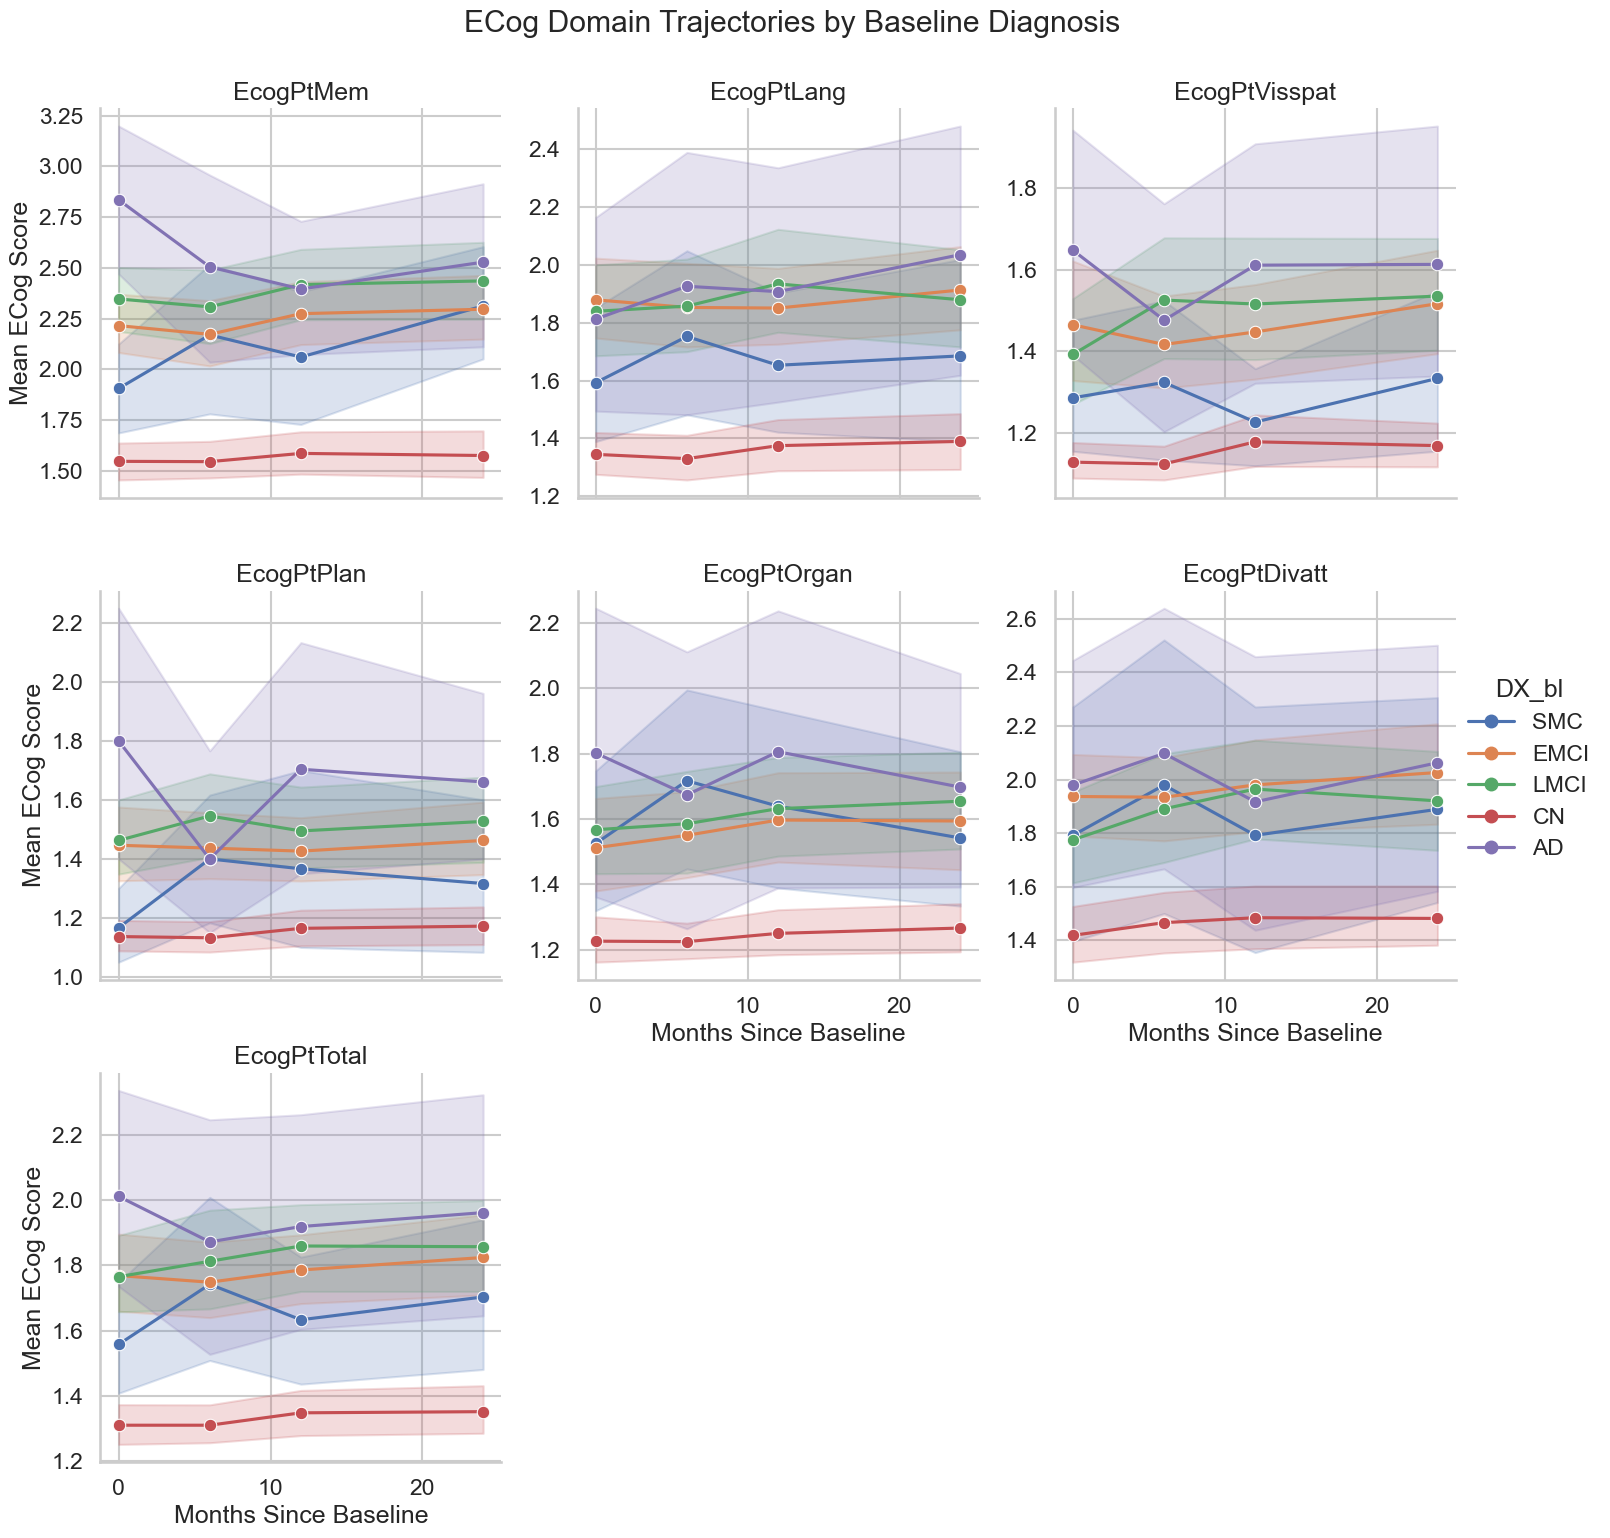

In [341]:
sns.set(style="whitegrid", context="talk")

g = sns.relplot(
    data=long_df,
    x="Month",
    y="Score",
    kind="line",
    hue="DX_bl",
    col="Domain",
    col_wrap=3,
    marker="o",
    facet_kws={"sharey": False, "sharex": True}
)

g.fig.suptitle("ECog Domain Trajectories by Baseline Diagnosis", y=1.03)
g.set_axis_labels("Months Since Baseline", "Mean ECog Score")
g.set_titles("{col_name}")
plt.show()

In [342]:
long_df


,PTID,DX_bl,Domain_Time,Score,Domain,Month
0,032_S_5263,SMC,EcogPtMem_bl,1.875,EcogPtMem,0.0
1,029_S_5135,EMCI,EcogPtMem_bl,1.875,EcogPtMem,0.0
2,027_S_5127,SMC,EcogPtMem_bl,2.000,EcogPtMem,0.0
3,027_S_5118,SMC,EcogPtMem_bl,2.000,EcogPtMem,0.0
4,041_S_5100,SMC,EcogPtMem_bl,1.625,EcogPtMem,0.0
...,...,...,...,...,...,...
8699,021_S_5099,EMCI,RAVLT_learning_24,5.000,NaN,NaN
8700,135_S_5113,SMC,RAVLT_learning_24,5.000,NaN,NaN
8701,012_S_5121,SMC,RAVLT_learning_24,8.000,NaN,NaN
8702,041_S_5141,SMC,RAVLT_learning_24,9.000,NaN,NaN


In [343]:
# work with just EcogPtMem - i did do this but chose against
# acc this isnt great as its down to the patients own perception
# now use the RAVLT_learning

tests = ['RAVLT_learning_bl','RAVLT_learning_6','RAVLT_learning_12','RAVLT_learning_24']
timepoints = np.array([0, 6, 12, 24]).reshape(-1, 1)

In [344]:
full_df

,PTID,PTGENDER,AGE,PTRACCAT,PTEDUCAT,DX_bl,EcogSPPlan_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,...,EcogPtPlan_24,EcogPtOrgan_24,EcogPtDivatt_24,EcogPtTotal_24,EcogSPMem_24,EcogSPLang_24,EcogSPVisspat_24,EcogSPOrgan_24,EcogSPDivatt_24,RAVLT_learning_24
0,032_S_5263,Female,75.2,White,18,SMC,1.0,1.875,1.11111,1.00000,...,1.0,1.00000,1.75,1.28205,2.750,1.88889,1.42857,1.66667,3.00,5.0
3,029_S_5135,Male,77.0,White,16,EMCI,1.4,1.875,1.44444,1.00000,...,1.2,1.00000,2.50,1.43590,2.000,1.11111,1.14286,1.00000,3.00,4.0
4,027_S_5127,Female,76.3,White,19,SMC,1.2,2.000,1.55556,1.14286,...,1.2,1.33333,2.25,1.46154,2.375,1.00000,1.00000,1.80000,1.50,6.0
5,027_S_5118,Female,68.2,White,20,SMC,1.0,2.000,1.44444,1.00000,...,1.0,1.33333,1.50,1.53846,2.000,1.33333,1.00000,1.33333,2.50,3.0
8,041_S_5100,Male,71.2,White,16,SMC,1.0,1.625,2.22222,1.57143,...,1.0,1.33333,2.00,2.07692,1.000,1.22222,1.00000,1.00000,1.00,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,021_S_5099,Female,61.6,White,16,EMCI,1.4,3.750,2.77778,3.85714,...,2.8,3.33333,4.00,3.28947,2.000,1.88889,1.57143,1.50000,2.25,5.0
397,135_S_5113,Male,65.1,White,16,SMC,1.0,1.500,1.55556,1.28571,...,1.0,1.33333,1.25,1.35897,1.250,1.11111,1.00000,1.00000,1.00,5.0
398,012_S_5121,Male,76.8,White,16,SMC,3.4,1.250,1.22222,1.14286,...,1.4,1.50000,1.75,1.53846,3.500,2.66667,2.28571,4.00000,3.25,8.0
399,041_S_5141,Male,76.7,White,18,SMC,1.8,1.625,1.33333,1.14286,...,1.2,1.50000,1.00,1.41026,1.875,2.11111,1.42857,1.50000,1.75,9.0


In [345]:

slopes = []
for index, row in full_df.iterrows():
    test_scores = [row[col] for col in tests]
    
    
    model = LinearRegression()
    model.fit(timepoints, test_scores)
    slopes.append(model.coef_[0])
    
full_df["RAVLT_learning_LR"] = slopes

In [346]:
full_df["RAVLT_learning_LR"]

0     -0.085714
3      0.014286
4      0.061905
5     -0.100000
8      0.047619
         ...   
395    0.014286
397    0.028571
398    0.066667
399    0.019048
400   -0.095238
Name: RAVLT_learning_LR, Length: 272, dtype: float64

In [347]:
pet = pd.read_csv("data/CSF_COG_PET_data.csv")
pet

,PTID,TAU_bl,PTAU_bl,ABETA_bl,EXAMDATE,EXAMDATE_bl,DX_bl,DX,AGE,PTGENDER,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,082_S_5282,170.70,15.63,558.9,2015-11-19,2013-09-09,SMC,CN,66.9,Male,...,0.003690,0.012155,0.032376,0.018102,0.008745,0.014004,0.009032,0.006589,0.000833,0.000720
1,100_S_5280,101.20,10.08,731.8,2015-09-29,2013-09-17,SMC,CN,67.5,Male,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
2,027_S_5277,324.80,34.39,780.3,2015-08-31,2013-08-28,SMC,CN,71.8,Female,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
3,135_S_5275,490.40,53.18,832.7,2014-02-25,2013-08-27,AD,Dementia,78.0,Female,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
4,135_S_5269,108.20,10.55,590.4,2015-09-01,2013-08-20,SMC,CN,64.9,Male,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,127_S_5266,279.90,24.28,>1700,2015-08-06,2013-08-15,SMC,CN,65.9,Male,...,0.003873,0.012135,0.034131,0.018864,0.008398,0.011478,0.009674,0.007555,0.000818,0.000764
543,053_S_5272,305.00,25.05,>1700,2015-09-15,2013-09-04,SMC,CN,69.9,Female,...,0.003308,0.010313,0.029413,0.016943,0.008936,0.011930,0.008579,0.006243,0.000678,0.000581
544,053_S_5287,268.40,26.11,>1700,2015-09-30,2013-09-18,SMC,CN,78.9,Female,...,0.003723,0.011469,0.026939,0.015693,0.008374,0.011329,0.008016,0.006976,0.000753,0.000723
545,027_S_5288,300.10,26.59,>1700,2015-09-24,2013-09-25,SMC,CN,81.9,Female,...,0.003486,0.011536,0.031103,0.017387,0.008620,0.010525,0.007063,0.005713,0.000815,0.000768


In [348]:
suvr_cols = [col for col in pet.columns if col.startswith("SUVr")]
scaler = StandardScaler()
pet_scaled = scaler.fit_transform(pet[suvr_cols])
pet_scaled_df = pd.DataFrame(pet_scaled, columns=suvr_cols, index=pet.index)

In [349]:
ptid_col = pet[["PTID"]]

pet_scaled_df = ptid_col.join(pd.DataFrame(pet_scaled, columns=suvr_cols, index=pet.index))

pet = pet_scaled_df

pet

,PTID,SUVr_ACC_pre_L.nii,SUVr_ACC_pre_R.nii,SUVr_ACC_sub_L.nii,SUVr_ACC_sub_R.nii,SUVr_ACC_sup_L.nii,SUVr_ACC_sup_R.nii,SUVr_Amygdala_L.nii,SUVr_Amygdala_R.nii,SUVr_Angular_L.nii,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,082_S_5282,-0.374472,-0.103493,-0.082648,0.149512,-0.219964,0.087711,-0.050003,0.760850,-0.465340,...,0.382271,0.536020,0.205339,-0.025831,-0.231994,1.459763,0.272135,0.509360,0.359058,-0.148931
1,100_S_5280,-0.997314,-0.923759,-0.933812,-0.941598,-0.667164,-0.702742,-0.579239,-0.658879,-1.308810,...,-0.425863,-0.207902,-0.338123,0.073580,0.426510,-0.301789,0.105441,-0.015421,-0.930227,-0.849846
2,027_S_5277,1.190444,1.091232,1.135333,0.869919,1.434216,1.264608,0.710575,0.813009,2.011813,...,-0.538397,-0.305116,-1.018155,-0.814352,0.207322,0.330036,-0.834024,-0.311783,-0.306831,-0.393020
3,135_S_5275,1.591171,1.579257,1.620230,1.430354,1.084072,1.247037,1.114339,0.592394,1.756109,...,-0.343134,0.109891,0.657872,0.712333,1.788157,0.529201,-1.093910,-0.749670,0.054527,0.314582
4,135_S_5269,-0.196986,-0.236262,-0.475751,-0.201899,-0.021358,-0.220245,0.003961,-0.023989,-0.715688,...,-0.432052,0.379576,0.822918,1.113989,1.301616,0.428308,1.111935,0.544578,-0.542861,-0.665232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,127_S_5266,0.018681,0.049310,-0.620904,-0.301818,-0.339582,0.213057,1.183131,0.470199,-1.075852,...,0.844934,0.517934,0.842702,0.475620,-0.652798,-0.673012,0.984589,1.923783,0.201758,0.359399
543,053_S_5272,-0.697933,-0.413572,-0.722696,-0.813415,-0.526303,-0.271298,-0.614744,-0.498066,-0.104002,...,-0.581777,-1.168597,-0.870720,-0.787696,-0.000559,-0.291093,-0.228806,0.002545,-1.295092,-1.756164
544,053_S_5287,-0.540517,-0.330666,-0.272743,-0.262321,0.129859,0.472484,-1.251811,-1.322668,-0.265070,...,0.464425,-0.099148,-1.769382,-1.610279,-0.682351,-0.798104,-0.853510,1.076330,-0.493998,-0.108116
545,027_S_5288,-1.367509,-0.978707,-1.162523,-1.083937,-1.056846,-0.661577,-0.838976,-0.698281,-0.854652,...,-0.130637,-0.036668,-0.256924,-0.496092,-0.383373,-1.477163,-1.909364,-0.774277,0.165936,0.410707


In [350]:
full_df = full_df.merge(pet, on="PTID")

In [351]:
full_df

,PTID,PTGENDER,AGE,PTRACCAT,PTEDUCAT,DX_bl,EcogSPPlan_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,032_S_5263,Female,75.2,White,18,SMC,1.0,1.875,1.11111,1.00000,...,0.455022,-0.086476,0.420261,2.726616,2.293333,1.224697,0.749801,1.252462,-0.072853,-0.752345
1,029_S_5135,Male,77.0,White,16,EMCI,1.4,1.875,1.44444,1.00000,...,-0.930260,-0.871309,-0.909920,-1.177831,-1.375431,-0.897801,-0.360087,-0.699309,-1.260724,-1.388070
2,027_S_5127,Female,76.3,White,19,SMC,1.2,2.000,1.55556,1.14286,...,0.387290,-1.429755,-0.495036,0.274397,0.255058,-0.156760,-0.770377,-0.182501,0.769353,0.064929
3,027_S_5118,Female,68.2,White,20,SMC,1.0,2.000,1.44444,1.00000,...,-2.041372,-2.277337,-1.595890,-1.145839,-0.130069,0.202357,-0.346203,-1.509454,-2.144032,-2.414541
4,041_S_5100,Male,71.2,White,16,SMC,1.0,1.625,2.22222,1.57143,...,0.626509,0.038330,-0.205843,1.065258,-0.951127,-1.436217,-0.417258,0.173636,0.425495,0.177747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,021_S_5099,Female,61.6,White,16,EMCI,1.4,3.750,2.77778,3.85714,...,-1.364719,-1.575587,-1.119724,-0.356474,0.525181,-0.073342,-0.793322,-0.374372,-1.421969,-1.391795
268,135_S_5113,Male,65.1,White,16,SMC,1.0,1.500,1.55556,1.28571,...,0.385137,0.324317,0.516250,0.575415,0.162784,-1.408031,-0.544393,-0.139132,0.490489,0.447299
269,012_S_5121,Male,76.8,White,16,SMC,3.4,1.250,1.22222,1.14286,...,0.658467,-0.076389,-0.494637,-0.392351,-0.150003,-0.591886,-0.946270,0.155649,0.679271,0.782607
270,041_S_5141,Male,76.7,White,18,SMC,1.8,1.625,1.33333,1.14286,...,-0.263249,0.351720,-0.821941,-1.159733,-0.024683,0.212329,-0.235468,0.003014,0.632941,0.498999


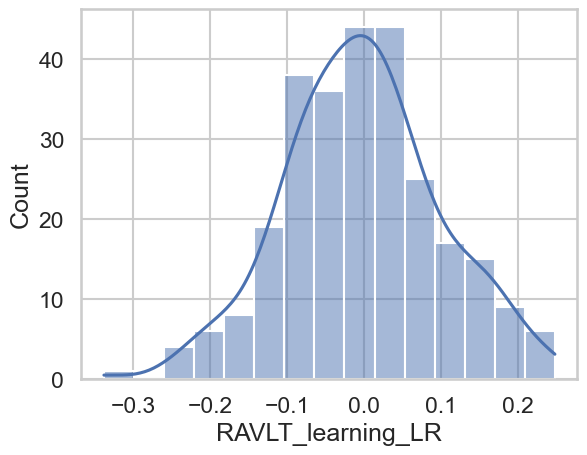

In [393]:
sns.histplot(full_df, x ='RAVLT_learning_LR', kde=True)
plt.show()

In [353]:
from sklearn.cluster import KMeans


In [392]:
full_df.columns

Index(['PTID', 'PTGENDER', 'AGE', 'PTRACCAT', 'PTEDUCAT', 'DX_bl',
       'EcogSPPlan_bl', 'EcogPtMem_bl', 'EcogPtLang_bl', 'EcogPtVisspat_bl',
       ...
       'SUVr_Vermis_3.nii', 'SUVr_Vermis_4_5.nii', 'SUVr_Vermis_6.nii',
       'SUVr_Vermis_7.nii', 'SUVr_Vermis_8.nii', 'SUVr_Vermis_9.nii',
       'SUVr_Vermis_10.nii', 'SUVr_VTA_L.nii', 'SUVr_VTA_R.nii', 'cluster'],
      dtype='object', length=233)

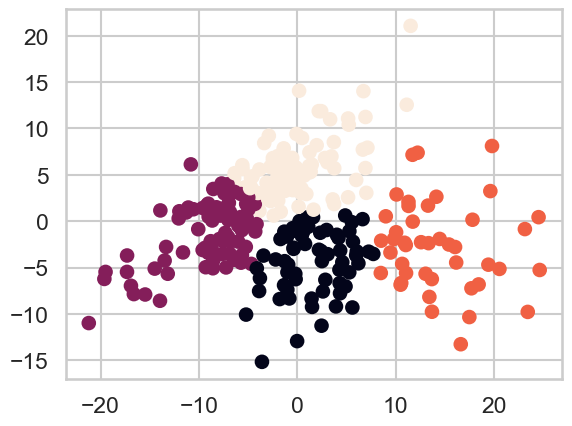

In [416]:
X = full_df.filter(suvr_cols)

kmeans = KMeans(n_clusters = 4, random_state=42)
clusters = kmeans.fit_predict(X)
full_df['cluster'] = clusters

embedding = PCA(n_components=2).fit_transform(X)
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters)
plt.show()

In [417]:
full_df['cluster'].value_counts()

cluster
3    86
1    79
0    64
2    43
Name: count, dtype: int64

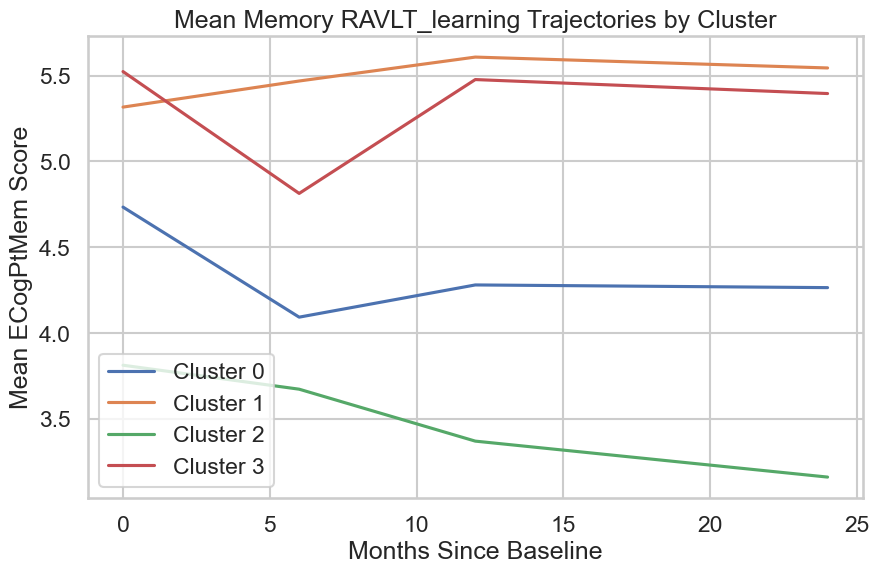

In [418]:
tests = ['RAVLT_learning_bl', 'RAVLT_learning_6', 'RAVLT_learning_12', 'RAVLT_learning_24']
timepoints = [0, 6, 12, 24]

plt.figure(figsize=(10, 6))
for cluster in sorted(full_df['cluster'].unique()):
    mean_scores = full_df[full_df['cluster'] == cluster][tests].mean()
    sns.lineplot(x=timepoints, y=mean_scores, label=f"Cluster {cluster}")

plt.title("Mean Memory RAVLT_learning Trajectories by Cluster")
plt.xlabel("Months Since Baseline")
plt.ylabel("Mean ECogPtMem Score")
plt.grid(True)
plt.legend()

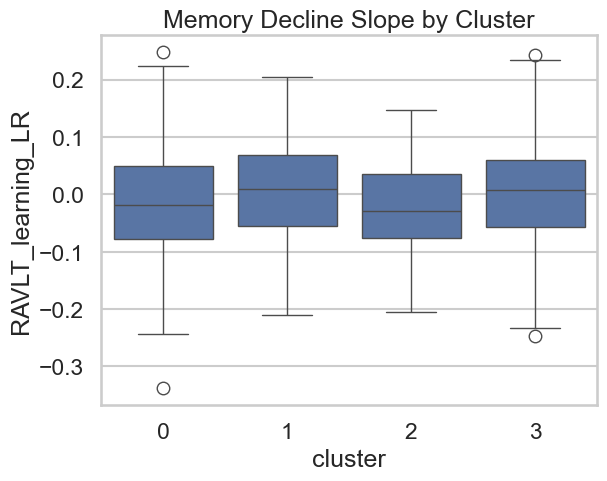

In [419]:
sns.boxplot(data=full_df, x='cluster', y='RAVLT_learning_LR')
plt.title("Memory Decline Slope by Cluster")
plt.show()

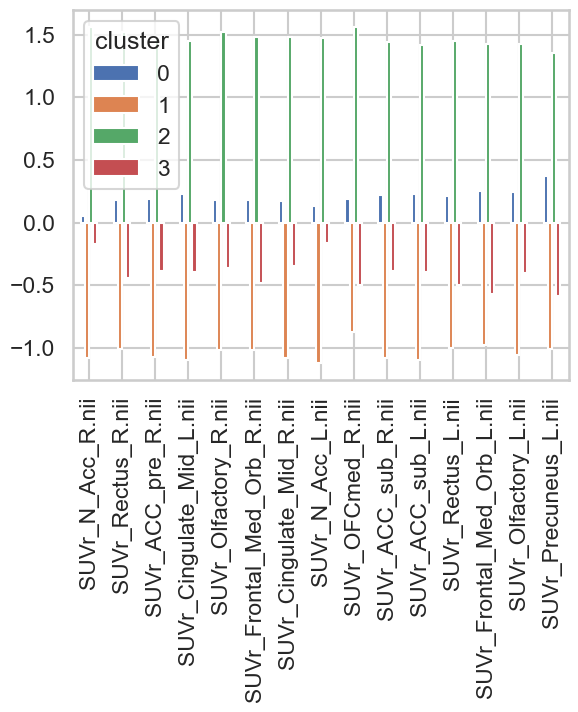

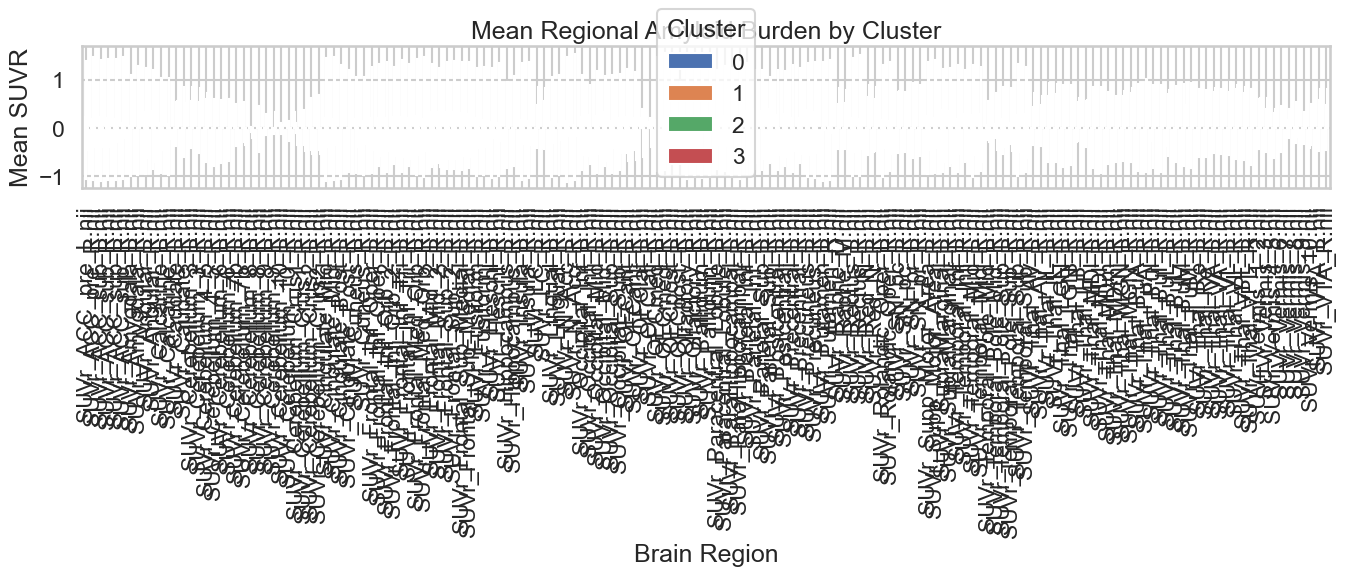

In [420]:
suvr_cols = [col for col in full_df.columns if col.startswith("SUVr")]

mean_pet_by_cluster = full_df.groupby('cluster')[suvr_cols].mean().T
top_diff = mean_pet_by_cluster.std(axis=1).sort_values(ascending=False).head(15).index
mean_pet_by_cluster.loc[top_diff].plot(kind='bar')
mean_pet_by_cluster.plot(kind='bar', figsize=(14, 6))
plt.title("Mean Regional Amyloid Burden by Cluster")
plt.ylabel("Mean SUVR")
plt.xlabel("Brain Region")
plt.legend(title='Cluster', )
plt.tight_layout()
plt.show()

In [421]:
print(mean_pet_by_cluster)

cluster                    0         1         2         3
SUVr_ACC_pre_L.nii  0.222573 -1.056532  1.392341 -0.451976
SUVr_ACC_pre_R.nii  0.188216 -1.074243  1.481482 -0.388155
SUVr_ACC_sub_L.nii  0.225734 -1.094838  1.412846 -0.394941
SUVr_ACC_sub_R.nii  0.216640 -1.077343  1.438430 -0.388865
SUVr_ACC_sup_L.nii  0.188316 -1.073189  1.425061 -0.291292
...                      ...       ...       ...       ...
SUVr_Vermis_8.nii   0.014974 -0.314463  0.530581 -0.179217
SUVr_Vermis_9.nii  -0.137217 -0.323684  0.336893  0.148193
SUVr_Vermis_10.nii -0.408341 -0.355773  0.490756  0.423570
SUVr_VTA_L.nii     -0.322136 -0.470454  0.583304  0.812545
SUVr_VTA_R.nii     -0.377945 -0.449073  0.477873  0.809631

[166 rows x 4 columns]


In [422]:
c_0 = full_df[full_df['cluster'] == 0]
c_1 = full_df[full_df['cluster'] == 1]
c_2 = full_df[full_df['cluster'] == 2]
c_3 = full_df[full_df['cluster'] == 3]


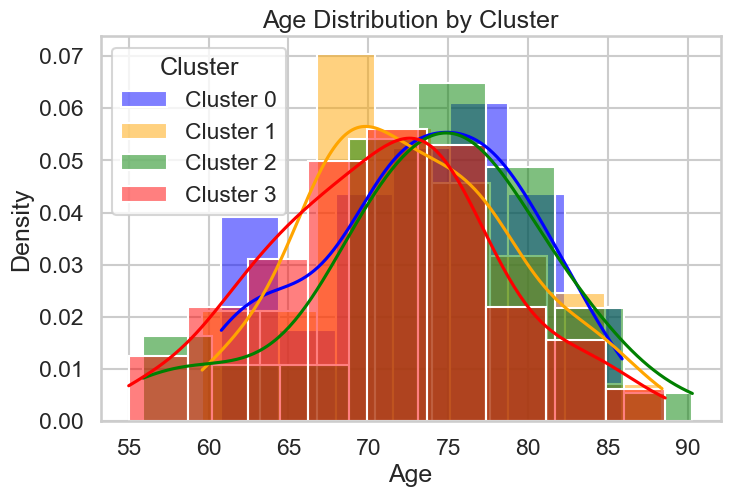

In [423]:
plt.figure(figsize=(8, 5))

sns.histplot(c_0['AGE'], color='blue', label='Cluster 0', kde=True, stat='density', alpha=0.5)
sns.histplot(c_1['AGE'], color='orange', label='Cluster 1', kde=True, stat='density', alpha=0.5)
sns.histplot(c_2['AGE'], color='green', label='Cluster 2', kde=True, stat='density', alpha=0.5)
sns.histplot(c_3['AGE'], color='red', label='Cluster 3', kde=True, stat='density', alpha=0.5)

plt.legend(title='Cluster')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution by Cluster')
plt.show()



C:\Users\huw\AppData\Local\Temp\ipykernel_3360\525151696.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\huw\AppData\Local\Temp\ipykernel_3360\525151696.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\huw\AppData\Local\Temp\ipykernel_3360\525151696.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

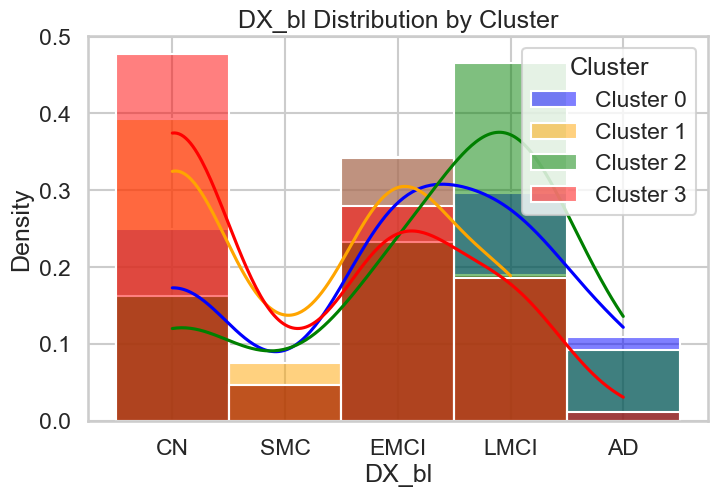

In [424]:
plt.figure(figsize=(8, 5))
# Define the desired order
dx_order = ["CN", "SMC", "EMCI", "LMCI", "AD"]

# Convert DX_bl to categorical with that order
c_0['DX_bl'] = pd.Categorical(c_0['DX_bl'], categories=dx_order, ordered=True)
c_1['DX_bl'] = pd.Categorical(c_1['DX_bl'], categories=dx_order, ordered=True)
c_2['DX_bl'] = pd.Categorical(c_2['DX_bl'], categories=dx_order, ordered=True)
c_3['DX_bl'] = pd.Categorical(c_3['DX_bl'], categories=dx_order, ordered=True)

sns.histplot(c_0['DX_bl'], color='blue', label='Cluster 0', kde=True, stat='density', alpha=0.5)
sns.histplot(c_1['DX_bl'], color='orange', label='Cluster 1', kde=True, stat='density', alpha=0.5)
sns.histplot(c_2['DX_bl'], color='green', label='Cluster 2', kde=True, stat='density', alpha=0.5)
sns.histplot(c_3['DX_bl'], color='red', label='Cluster 3', kde=True, stat='density', alpha=0.5)

plt.legend(title='Cluster')
plt.xlabel('DX_bl')
plt.ylabel('Density')
plt.title('DX_bl Distribution by Cluster')
plt.show()

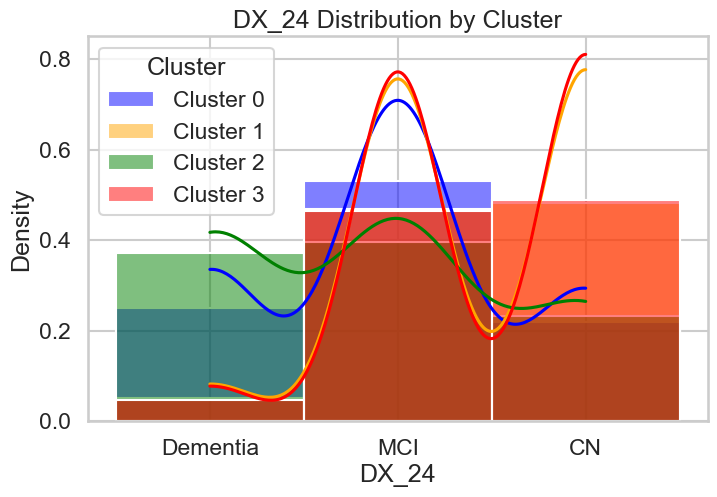

In [425]:
plt.figure(figsize=(8, 5))

sns.histplot(c_0['DX_24'], color='blue', label='Cluster 0', kde=True, stat='density', alpha=0.5)
sns.histplot(c_1['DX_24'], color='orange', label='Cluster 1', kde=True, stat='density', alpha=0.5)
sns.histplot(c_2['DX_24'], color='green', label='Cluster 2', kde=True, stat='density', alpha=0.5)
sns.histplot(c_3['DX_24'], color='red', label='Cluster 3', kde=True, stat='density', alpha=0.5)

plt.legend(title='Cluster')
plt.xlabel('DX_24')
plt.ylabel('Density')
plt.title('DX_24 Distribution by Cluster')
plt.show()

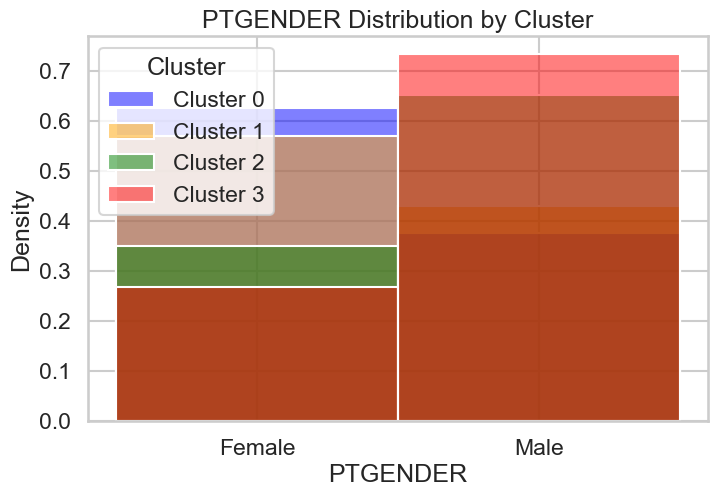

In [426]:
plt.figure(figsize=(8, 5))

sns.histplot(c_0['PTGENDER'], color='blue', label='Cluster 0',  stat='density', alpha=0.5)
sns.histplot(c_1['PTGENDER'], color='orange', label='Cluster 1',  stat='density', alpha=0.5)
sns.histplot(c_2['PTGENDER'], color='green', label='Cluster 2', stat='density', alpha=0.5)
sns.histplot(c_3['PTGENDER'], color='red', label='Cluster 3',  stat='density', alpha=0.5)

plt.legend(title='Cluster')
plt.xlabel('PTGENDER')
plt.ylabel('Density')
plt.title('PTGENDER Distribution by Cluster')
plt.show()

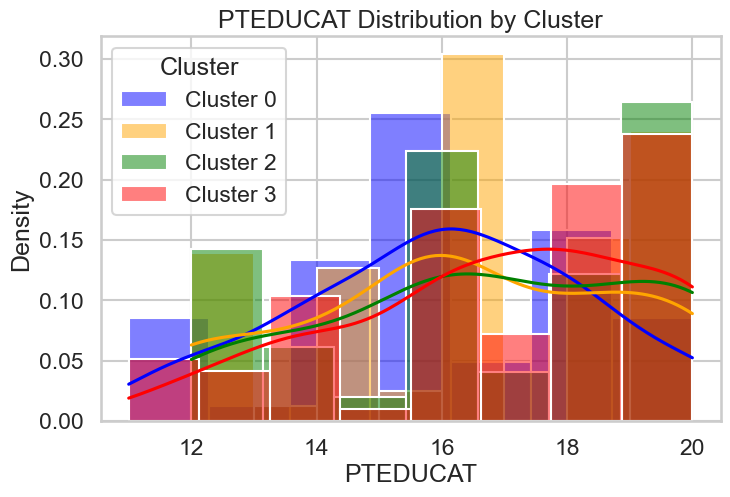

In [427]:
plt.figure(figsize=(8, 5))

sns.histplot(c_0['PTEDUCAT'], color='blue', label='Cluster 0', kde=True, stat='density', alpha=0.5)
sns.histplot(c_1['PTEDUCAT'], color='orange', label='Cluster 1', kde=True, stat='density', alpha=0.5)
sns.histplot(c_2['PTEDUCAT'], color='green', label='Cluster 2', kde=True, stat='density', alpha=0.5)
sns.histplot(c_3['PTEDUCAT'], color='red', label='Cluster 3', kde=True, stat='density', alpha=0.5)

plt.legend(title='Cluster')
plt.xlabel('PTEDUCAT')
plt.ylabel('Density')
plt.title('PTEDUCAT Distribution by Cluster')
plt.show()

In [428]:
print(c_0[suvr_cols].mean().sort_values(ascending=False).head(10))

SUVr_Parietal_Inf_R.nii        0.400367
SUVr_Parietal_Sup_R.nii        0.397061
SUVr_Precuneus_L.nii           0.369169
SUVr_SupraMarginal_L.nii       0.365753
SUVr_SupraMarginal_R.nii       0.353053
SUVr_Parietal_Sup_L.nii        0.350907
SUVr_Parietal_Inf_L.nii        0.349895
SUVr_Angular_R.nii             0.343802
SUVr_Precuneus_R.nii           0.338735
SUVr_Cerebellum_Crus1_L.nii    0.335437
dtype: float64


In [429]:
print(c_1[suvr_cols].mean().sort_values(ascending=False).head(10))

SUVr_Cerebellum_Crus2_R.nii    0.675017
SUVr_Cerebellum_Crus2_L.nii    0.631680
SUVr_Cerebellum_7b_R.nii       0.547970
SUVr_Cerebellum_7b_L.nii       0.493589
SUVr_Cerebellum_8_R.nii        0.459419
SUVr_Cerebellum_Crus1_R.nii    0.370482
SUVr_Cerebellum_10_R.nii       0.140399
SUVr_OFClat_R.nii              0.121384
SUVr_OFClat_L.nii              0.116934
SUVr_Cerebellum_Crus1_L.nii    0.113194
dtype: float64


In [430]:
print(c_2[suvr_cols].mean().sort_values(ascending=False).head(10))

SUVr_N_Acc_R.nii              1.562415
SUVr_OFCmed_R.nii             1.557075
SUVr_Rectus_R.nii             1.520907
SUVr_Olfactory_R.nii          1.519956
SUVr_Frontal_Med_Orb_R.nii    1.482918
SUVr_ACC_pre_R.nii            1.481482
SUVr_Cingulate_Mid_R.nii      1.476746
SUVr_N_Acc_L.nii              1.475789
SUVr_OFCmed_L.nii             1.474038
SUVr_ACC_sup_R.nii            1.465970
dtype: float64


In [431]:
print(c_3[suvr_cols].mean().sort_values(ascending=False).head(10))

SUVr_Thal_VL_L.nii         0.953229
SUVr_Thal_IL_L.nii         0.926575
SUVr_Thal_IL_R.nii         0.922642
SUVr_Red_N_L.nii           0.896908
SUVr_Thal_VL_R.nii         0.886223
SUVr_Thal_VA_L.nii         0.857506
SUVr_Thal_VPL_L.nii        0.855533
SUVr_Cerebellum_3_R.nii    0.847787
SUVr_Cerebellum_3_L.nii    0.847538
SUVr_LC_L.nii              0.845297
dtype: float64


In [432]:
c_0.value_counts(subset=['DX_bl','DX_24'])

DX_bl  DX_24   
EMCI   MCI         19
CN     CN          12
LMCI   MCI         10
       Dementia     9
AD     Dementia     6
CN     MCI          4
EMCI   CN           2
       Dementia     1
AD     MCI          1
Name: count, dtype: int64

In [433]:
c_1.value_counts(subset=['DX_bl','DX_24'])

DX_bl  DX_24   
CN     CN          30
EMCI   MCI         26
LMCI   MCI         10
SMC    CN           5
LMCI   Dementia     3
       CN           2
EMCI   CN           1
CN     MCI          1
SMC    Dementia     1
Name: count, dtype: int64

In [434]:
c_2.value_counts(subset=['DX_bl','DX_24'])

DX_bl  DX_24   
LMCI   MCI         11
       Dementia     9
CN     CN           7
EMCI   MCI          5
AD     Dementia     4
EMCI   Dementia     3
       CN           2
SMC    CN           1
       MCI          1
Name: count, dtype: int64

In [435]:
c_3.value_counts(subset=['DX_bl','DX_24'])

DX_bl  DX_24   
CN     CN          36
EMCI   MCI         22
LMCI   MCI         14
SMC    CN           3
CN     MCI          3
       Dementia     2
EMCI   CN           2
SMC    MCI          1
LMCI   CN           1
       Dementia     1
AD     Dementia     1
Name: count, dtype: int64